In [108]:
import numpy as np
import cv2
import tensorflow as tf
import os
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image

- READ train, validation, test images and mask
- Load the UNET pretrained model

In [109]:
model_path = "unet-14class/run560017516725536_classicUNET_RGB_images512x512_14classes_200epochs_augmented_lr0.001_HSV/best_unet_model_da.h5"
image_dir = "images_cropped/RGB/"
mask_dir = "gt-masks/segmap14c"
test_txt = "train-val-test/test.txt"
validation_txt = "train-val-test/validation.txt"
train_txt = "train-val-test/test.txt"

class CustomMeanIoU(MeanIoU):
    def __init__(self, num_classes):
        super().__init__(num_classes=num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

CLASSES = 14
model = tf.keras.models.load_model(model_path, compile=False)

LEARNING_RATE = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)        

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[CustomMeanIoU(num_classes=CLASSES)])

def read_txt_files(image_dir, mask_dir, txt_file):
    images = []
    masks = []
    
    with open(txt_file, 'r') as file:
        lines = file.readlines()
        
        for line in lines:
            line = line.strip()
            
            img_path = os.path.join(image_dir, line)
            mask_path = os.path.join(mask_dir, line)
            
            img = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
            
            images.append(img)
            masks.append(mask)
            
    return images, masks

test_images, test_masks = read_txt_files(image_dir, mask_dir, test_txt)
validation_images, validation_masks = read_txt_files(image_dir, mask_dir, validation_txt)
train_images, train_masks = read_txt_files(image_dir, mask_dir, train_txt)

print("Test, validation, and train data loaded successfully.")

Test, validation, and train data loaded successfully.


Visualize some examples of each train, validation, test set images and masks to ensure they match

Train set:


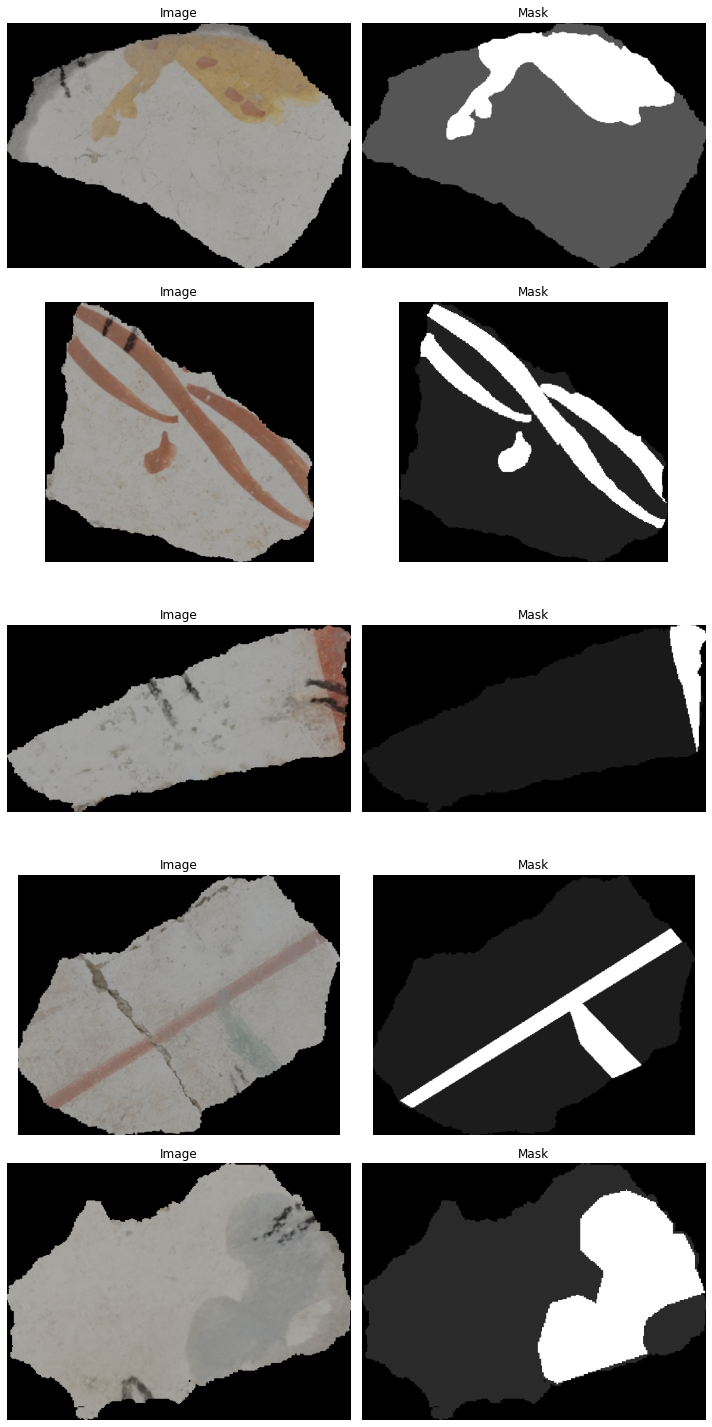

Validation set:


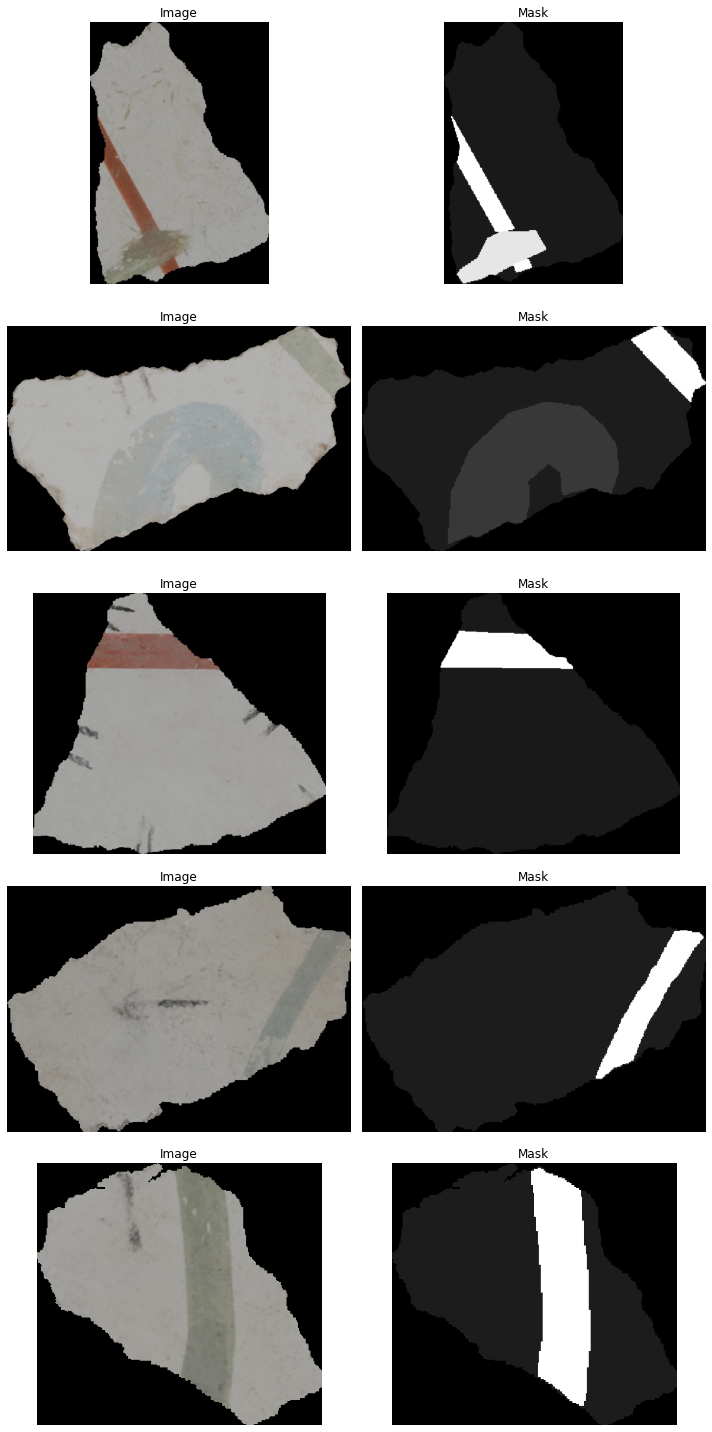

Test set:


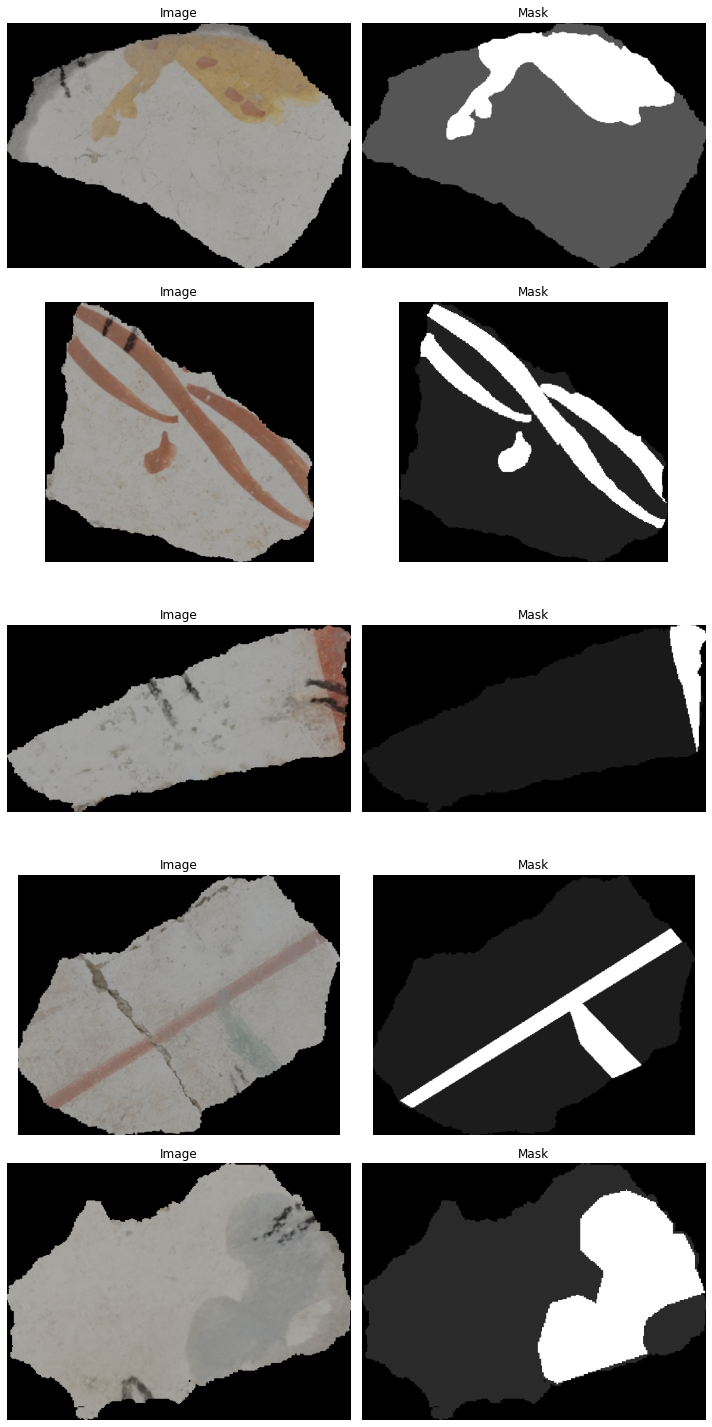

In [110]:
def visualize_data(images, masks, num_samples=5):
    fig, ax = plt.subplots(num_samples, 2, figsize=(10, 20))

    for i in range(num_samples):
        img = images[i]
        mask = masks[i]

        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 0].set_title("Image")
        ax[i, 0].axis('off')

        ax[i, 1].imshow(mask, cmap='gray')
        ax[i, 1].set_title("Mask")
        ax[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

print("Train set:")
visualize_data(train_images, train_masks)

print("Validation set:")
visualize_data(validation_images, validation_masks)

print("Test set:")
visualize_data(test_images, test_masks)

- Resize to 512*512 and Color transformation to HSV  as preprocessing steps done in the github code
- Compute average meanIOU of Unet pretrained model on test images

In [111]:
from tensorflow.image import resize

test_images_np = [np.array(img) for img in test_images]
test_images_np = [tf.image.rgb_to_hsv(img) for img in test_images_np]
test_images_np_resized = [resize(img, (512, 512)) for img in test_images_np]

predictions = model.predict(np.array(test_images_np_resized))
predicted_maps = np.argmax(predictions, axis=-1)

test_masks_np = [np.array(mask) for mask in test_masks]

test_masks_np_resized = [tf.squeeze(resize(tf.expand_dims(tf.expand_dims(mask, 0), -1), 
                                           [predicted_maps.shape[1], predicted_maps.shape[2]])).numpy() 
                         for mask in test_masks_np]

miou = tf.keras.metrics.MeanIoU(num_classes=14)

iou_per_class = []
for i in range(14):
    temp_mask = np.equal(predicted_maps, i)
    temp_gt = np.equal(np.array(test_masks_np_resized), i)
    miou.reset_states()
    miou.update_state(temp_gt, temp_mask)
    iou_per_class.append(miou.result().numpy())

average_iou_excluded = np.mean(iou_per_class[2:])
average_iou_all = np.mean(iou_per_class)

print("Average IoU for all classes: ", average_iou_all)
print("Average IoU for classes 2-13: ", average_iou_excluded)

Average IoU for all classes:  0.4790664
Average IoU for classes 2-13:  0.467221


Save UNET predicted masks in a folder 

In [113]:
if not os.path.exists('predicted_masks'):
    os.makedirs('predicted_masks')

with open('train-val-test/test.txt', 'r') as f:
    original_filenames = f.read().splitlines()

for i, (pred_map, orig_filename) in enumerate(zip(predicted_maps, original_filenames)):
    img = Image.fromarray(pred_map.astype(np.uint8))
    img.save(f"predicted_masks/{orig_filename}")

Produce colorized versions of Unet predicted masks (the code coppied from https://github.com/RePAIRProject/fragment-restoration/blob/develop/Dataset_processing/colorize_segmentation_masks.py)

In [114]:
def colorize_mask(input_mask, color_mapping):
    colored_mask = np.zeros((input_mask.shape[0], input_mask.shape[1], 3), dtype=np.uint8)
    for class_label, color in color_mapping.items():
        colored_mask[input_mask == class_label] = color
    return colored_mask

color_mapping = {
    0: (0, 0, 0),           # Class 0 (Image Background - Black)
    1: (255, 255, 240),     # Class 1 (Fragment Background - Light Beige)
    2: (0, 0, 255),         # Class 2 (Bluebird - Blue)
    3: (204, 204, 0),       # Class 3 (Yellow Bird - Yellow)
    4: (255, 0, 0),         # Class 4 (Red Griffon - Red)
    5: (255, 179, 179),     # Class 5 (Red Flower - Red - Lighter Tone)
    6: (0, 128, 255),       # Class 6 (Blue Flower - Blue - Different Tone)
    7: (255, 77, 77),       # Class 7 (Red Circle - Red - Different Tone)
    8: (192, 0, 0),         # Class 8 (Red Spiral - Dark Red)
    9: (0, 255, 0),         # Class 9 (Curved Green Stripe - Green)
    10: (255, 204, 229),       # Class 10 (Thin Red Stripe - Red - Different Tone)
    11: (255, 0, 255),      # Class 11 (Thick Red Stripe - Magenta)
    12: (128, 128, 255),    # Class 12 (Thin Floral Stripe - Blue - Different Tone)
    13: (0, 255, 255)       # Class 13 (Thick Floral Stripe - Cyan)
}

os.makedirs('colored_predicted_masks', exist_ok=True)

for i, (pred_map, orig_filename) in enumerate(zip(predicted_maps, original_filenames)):
    # Colorize the predicted map
    mask_colored = colorize_mask(pred_map, color_mapping)

    # Save the colorized map
    plt.imsave(f"colored_predicted_masks/{orig_filename}", mask_colored)

Compute average meanIOU for Yolo predictions 

In [115]:
def load_images(directory):
    images = []
    for filename in os.listdir(directory):
        img = cv2.imread(os.path.join(directory, filename))
        if img is not None:
            # Convert to grayscale
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images.append(img_gray)
    return images


pred_masks_directory = 'yolov8-12class/segmentation_results_training_yolo_shapes_512'
pred_masks = load_images(pred_masks_directory)

pred_masks_resized = [cv2.resize(mask, (512, 512)) for mask in pred_masks]

assert len(pred_masks_resized) == len(test_masks_np_resized), "Number of predicted masks and ground truth masks do not match!"

miou = tf.keras.metrics.MeanIoU(num_classes=14)
iou_per_class = []

for i in range(14):
    temp_mask = [np.equal(mask, i) for mask in pred_masks_resized]
    temp_gt = [np.equal(mask, i) for mask in test_masks_np_resized]

    temp_mask = np.stack(temp_mask)
    temp_gt = np.stack(temp_gt)

    print(f"Shapes for class {i}: temp_mask - {temp_mask.shape}, temp_gt - {temp_gt.shape}")

    miou.reset_states()
    miou.update_state(temp_gt, temp_mask)
    iou_per_class.append(miou.result().numpy())

average_iou_excluded = np.mean(iou_per_class[2:])
average_iou_all = np.mean(iou_per_class)

print("Average IoU for all classes: ", average_iou_all)
print("Average IoU for classes 2-13: ", average_iou_excluded)

Shapes for class 0: temp_mask - (38, 512, 512), temp_gt - (38, 512, 512)
Shapes for class 1: temp_mask - (38, 512, 512), temp_gt - (38, 512, 512)
Shapes for class 2: temp_mask - (38, 512, 512), temp_gt - (38, 512, 512)
Shapes for class 3: temp_mask - (38, 512, 512), temp_gt - (38, 512, 512)
Shapes for class 4: temp_mask - (38, 512, 512), temp_gt - (38, 512, 512)
Shapes for class 5: temp_mask - (38, 512, 512), temp_gt - (38, 512, 512)
Shapes for class 6: temp_mask - (38, 512, 512), temp_gt - (38, 512, 512)
Shapes for class 7: temp_mask - (38, 512, 512), temp_gt - (38, 512, 512)
Shapes for class 8: temp_mask - (38, 512, 512), temp_gt - (38, 512, 512)
Shapes for class 9: temp_mask - (38, 512, 512), temp_gt - (38, 512, 512)
Shapes for class 10: temp_mask - (38, 512, 512), temp_gt - (38, 512, 512)
Shapes for class 11: temp_mask - (38, 512, 512), temp_gt - (38, 512, 512)
Shapes for class 12: temp_mask - (38, 512, 512), temp_gt - (38, 512, 512)
Shapes for class 13: temp_mask - (38, 512, 512),